In [4]:
from TradeGenerator import *
import matplotlib.pyplot as plt

In [5]:
file_name="rawTrade.csv"
import os.path
import pandas as pds
numOfClusters=4
trainingDataSize=330

In [6]:
if( os.path.isfile(file_name)  ):
    rawdf = pds.read_csv(file_name)
else:
    t = TradeGenerator()
    tList = t.prepareTradeList(tradingdays=360)
    rawdf = t.tradeListConvert2DataFrame(tList)
    rawdf.to_csv(file_name,index=False)
    

rawdf["total"] = rawdf["price"] * rawdf["quantity"]
df=rawdf

df=df.drop("tradeId",axis=1)

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin
from IPython.core.debugger import set_trace

class CategoryEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, attribute): # no *args or **kargs
        self.attribute = attribute
    def fit(self, X):
        return self  # nothing else to do
    def transform(self, X, y=None):
        #set_trace()
        _encoded, _categories = X[self.attribute].factorize()
        self.categoriesIndex = _categories
        X[self.attribute+"_cat"] = _encoded
        X.drop(self.attribute,axis=1 ,inplace=True)
        return X
        

In [8]:
from sklearn.preprocessing import StandardScaler
OrgTypeCategoryEncoder = CategoryEncoder("orgType")
CustCategoryEncoder = CategoryEncoder("cust")
SecCategoryEncoder = CategoryEncoder("secid")
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('OrgType', OrgTypeCategoryEncoder),
        ('Cust', CustCategoryEncoder),
            ('Sec', SecCategoryEncoder)
    ])

In [9]:
newdf=num_pipeline.fit_transform(df)

In [10]:
secIdInx = newdf["secid_cat"]
newdf = newdf.drop("secid_cat",axis=1)

In [11]:
newdf[(newdf["day"]<2) ].head()

,day,price,quantity,total,orgType_cat,cust_cat
0,0,116,3641449,422408084,0,0
1,1,119,4232588,503677972,1,0
360,0,90,3252845,292756050,1,1
361,1,115,7887405,907051575,1,1
720,0,98,8938437,875966826,3,2


In [12]:
trainXdf = newdf[(newdf["day"]<trainingDataSize) ]
trainYdf = newdf[(newdf["day"]>=trainingDataSize)]

In [13]:
trainXdf=trainXdf.drop("day",axis=1)
trainYdf = trainYdf.drop("day",axis=1)

In [14]:
trainYdf.head()

,price,quantity,total,orgType_cat,cust_cat
330,108,2725393,294342444,1,0
331,90,7757900,698211000,1,0
332,110,7576908,833459880,2,0
333,96,4860417,466600032,1,0
334,92,4487717,412869964,1,0


(row,col)=trainXdf.shape
data = np.zeros((len(CustCategoryEncoder.categoriesIndex),col), dtype=np.float32)
for c in range(len(CustCategoryEncoder.categoriesIndex)):
    custClassSet = trainXdf[ trainXdf["cust_cat"] ==c ]
    
    for j in range(0,col):
        data[c,j] = np.round(np.sum( custClassSet[custClassSet["orgType_cat"]==j]["total"] )/1000000)


In [15]:
def generateFeatures(tradeData,scale,custCategory,includeCount=False):
    (row,col)=tradeData.shape
    numCol = col*2 if includeCount else col
    data = np.zeros((len(custCategory.categoriesIndex),numCol), dtype=np.float32)
    for c in range(len(custCategory.categoriesIndex)):
        custClassSet = tradeData[ tradeData["cust_cat"] ==c ]
        for j in range(0,col):
            data[c,j] = np.round(np.sum( custClassSet[custClassSet["orgType_cat"]==j]["total"] )/scale)
            if(includeCount):
                data[c,j+col] = np.sum( custClassSet[custClassSet["orgType_cat"]==j]["total"].count() )
            
    return data

In [16]:
traindata = generateFeatures(trainXdf,1000000,CustCategoryEncoder,True)
trainLabelData = generateFeatures(trainYdf,1000000,CustCategoryEncoder,False)

In [17]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=numOfClusters, random_state=0).fit(traindata)

In [18]:
ll=pd.DataFrame(kmeans.labels_)

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

def plot2DCluster(kmeans,data,xaxis,yaxis,axisIndex,subplot=111):
    ll=pd.DataFrame(kmeans.labels_)
    numOfCluster = kmeans.n_clusters
    
    plt.subplot(subplot)
    colors = cm.rainbow(np.linspace(0, 1, numOfCluster))
    for c in range(0,numOfCluster):
        d = data[ll[0]==c]
        plt.scatter(d[:,xaxis],d[:,yaxis],c=colors[c],marker="o")
        plt.scatter(kmeans.cluster_centers_[c,xaxis],kmeans.cluster_centers_[c,yaxis],c=colors[c],marker="x")
        
    # rotate the axes and update
    plt.xlabel(axisIndex[xaxis], fontsize=14)
    plt.ylabel(axisIndex[yaxis], fontsize=14)
    #ax.set_zlabel("restaurant", fontsize=14)
    

def plot3DCluster(kmeans,data,xaxis,yaxis,zaxis,axisIndex):
    ll=pd.DataFrame(kmeans.labels_)
    numOfCluster = kmeans.n_clusters
    
   
    ax = Axes3D(fig)
    colors = cm.rainbow(np.linspace(0, 1, numOfCluster))
    for c in range(0,numOfCluster):
        d = data[ll[0]==c] #select the data of cluster
        ax.scatter(d[:,xaxis],d[:,yaxis],d[:,zaxis],c=colors[c],marker="o")
        ax.scatter(kmeans.cluster_centers_[c,xaxis],kmeans.cluster_centers_[c,yaxis],kmeans.cluster_centers_[c,zaxis],c=colors[c],marker="x")
        
    # rotate the axes and update
    ax.set_xlabel(axisIndex[xaxis], fontsize=14)
    ax.set_ylabel(axisIndex[yaxis], fontsize=14)
    ax.set_zlabel(axisIndex[zaxis], fontsize=14)
    #plt.show()

In [20]:
OrgTypeCategoryEncoder.categoriesIndex

Index(['tech', 'Gov', 'energy', 'airline', 'food'], dtype='object')

Clustering the past training data.....


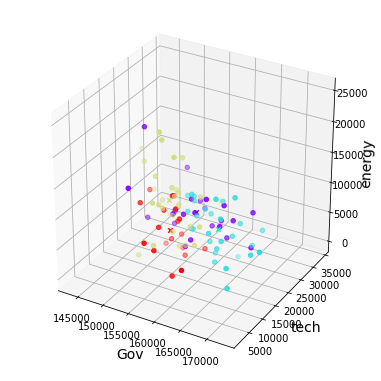

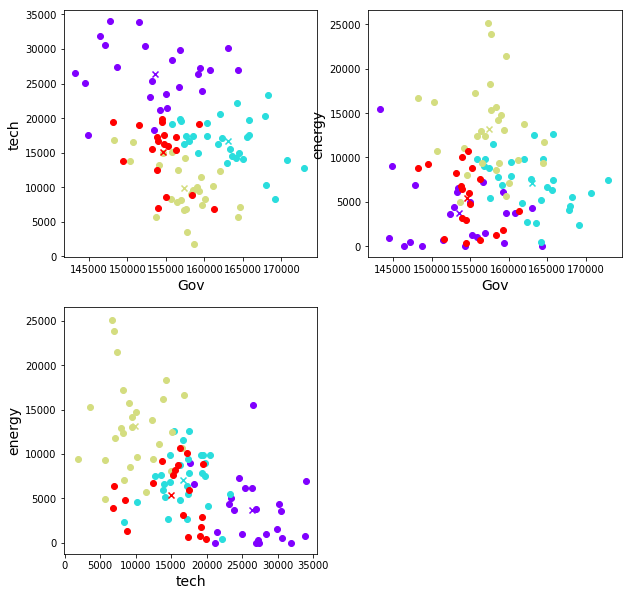

In [30]:
print ("Clustering the past training data.....")
fig = plt.figure(figsize=(5, 5))
plot3DCluster(kmeans,traindata,1,0,2,OrgTypeCategoryEncoder.categoriesIndex)
plt.show()
fig = plt.figure(figsize=(10, 10))
plot2DCluster(kmeans,traindata,1,0,OrgTypeCategoryEncoder.categoriesIndex,221)
plot2DCluster(kmeans,traindata,1,2,OrgTypeCategoryEncoder.categoriesIndex,222)
plot2DCluster(kmeans,traindata,0,2,OrgTypeCategoryEncoder.categoriesIndex,223)
plt.show()

In [22]:
print("Cluster centre:")
cSet=np.round(kmeans.cluster_centers_[:,0:len(OrgTypeCategoryEncoder.categoriesIndex)])
ClusterCenter = pds.DataFrame(cSet, columns=OrgTypeCategoryEncoder.categoriesIndex)
ClusterCenter

Cluster centre:


,tech,Gov,energy,airline,food
0,26444.0,153599.0,3682.0,1462.0,2862.0
1,16690.0,163059.0,7070.0,2503.0,3167.0
2,9848.0,157395.0,13183.0,2010.0,5893.0
3,15052.0,154646.0,5376.0,9427.0,3112.0


In [23]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(traindata, trainLabelData)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [24]:
predictedResult=tree_reg.predict(traindata[0].reshape(1,-1))
RegressionResult = pds.DataFrame(predictedResult, columns=OrgTypeCategoryEncoder.categoriesIndex)
print ( "With a client traded with position in million in the past {0} days".format(trainingDataSize))
print ( "Trade notional in millions:")
pds.DataFrame(traindata[0,0:5].reshape(1,-1), columns=OrgTypeCategoryEncoder.categoriesIndex)

With a client traded with position in million in the past 330 days
Trade notional in millions:


,tech,Gov,energy,airline,food
0,17347.0,160288.0,9444.0,4389.0,454.0


In [25]:
print ( "with number of deals:")
pds.DataFrame(np.int32(traindata[0,5:10].reshape(1,-1)), columns=OrgTypeCategoryEncoder.categoriesIndex)

with number of deals:


,tech,Gov,energy,airline,food
0,33,272,15,9,1


In [26]:
print ("Here is the predicted new trade position in million:")
RegressionResult

Here is the predicted new trade position in million:


,tech,Gov,energy,airline,food
0,0.0,15286.0,2365.0,0.0,0.0


In [27]:
XX=pds.DataFrame(traindata[:,0:5], columns=OrgTypeCategoryEncoder.categoriesIndex)
YY=pds.DataFrame(trainLabelData, columns=OrgTypeCategoryEncoder.categoriesIndex)

In [28]:
XX.describe()

,tech,Gov,energy,airline,food
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,16804.320312,157604.421875,7646.569824,3430.520020,3846.429932
std,7198.029785,5813.004883,5345.291016,4327.032715,4349.818848
min,1821.000000,143232.000000,0.000000,0.000000,0.000000
25%,12102.500000,154244.750000,3879.250000,0.000000,0.000000
50%,16611.500000,157470.500000,7171.000000,2031.500000,2083.000000
75%,20328.750000,161184.000000,9917.750000,4517.000000,5995.750000
max,33983.000000,172901.000000,25122.000000,18466.000000,20704.000000


In [29]:
YY.describe()

,tech,Gov,energy,airline,food
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1202.829956,14421.889648,930.090027,253.410004,256.760010
std,1243.159912,1750.188599,1251.720947,719.480408,623.148254
min,0.000000,10553.000000,0.000000,0.000000,0.000000
25%,0.000000,13103.000000,0.000000,0.000000,0.000000
50%,932.000000,14400.000000,108.500000,0.000000,0.000000
75%,2042.000000,15497.000000,1638.500000,0.000000,0.000000
max,5330.000000,18306.000000,4685.000000,3932.000000,2894.000000
